In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [3]:
rating = pd.read_csv('ml-20m/ratings.csv')
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


**Popularity-top 5**

In [4]:
movies = pd.read_csv('ml-20m/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
top_movies = rating.sort_values('rating', ascending=False)
tp=top_movies.head()

Final_popular=tp.join(movies.set_index('movieId'), on='movieId',how='inner')[['title','rating','genres']]

Final_popular.reset_index(level=0,inplace= True)
Final_popular

,index,title,rating,genres
0,10000131,Shine (1996),5.0,Drama|Romance
1,2404986,Mr. Holland's Opus (1995),5.0,Drama
2,2404972,Ransom (1996),5.0,Crime|Thriller
3,18011371,Taxi Driver (1976),5.0,Crime|Drama|Thriller
4,14582411,"Treasure of the Sierra Madre, The (1948)",5.0,Action|Adventure|Drama|Western


In [9]:
print("Number of Rows:", rating.shape[0])
print("Number of Columns:", rating.shape[1])

Number of Rows: 20000263
Number of Columns: 4


In [10]:
print("Number of Rows:", movies.shape[0])
print("Number of Columns:", movies.shape[1])

Number of Rows: 27278
Number of Columns: 3


**Unique users**

In [11]:
n_users = rating.userId.unique().shape[0]
n_users

138493

**How many unique items / movies?**

In [12]:
n_items = rating.movieId.unique().shape[0]
n_items

26744

**Feature Extraction for content filtering** 

In [13]:
import re
movies['Split']="X"
for i in range(0,movies.index[-1]):
    split_data=re.split(r'[|]', movies['genres'][i])
    for k,l in enumerate(split_data):
        split_data[k]=(split_data[k].replace(" ", ""))
    split_data=' '.join(split_data[:])
    movies['Split'].iloc[i]=split_data

/Users/harshwardhanbabel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
movies.head()

,movieId,title,genres,Split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,Comedy


TFIDF Vectorizer

In [15]:
#Extracting Stopword
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN for empty string
movies['Split'] = movies['Split'].fillna('')

#Applying TF-IDF Vectorizer
tfidf_matrix = tfidf.fit_transform(movies['Split'])

In [16]:
cosine_sim=linear_kernel(tfidf_matrix,tfidf_matrix)

In [17]:
print(cosine_sim)

[[1.         0.81341975 0.15917743 ... 0.4191766  0.         0.        ]
 [0.81341975 1.         0.         ... 0.51532631 0.         0.        ]
 [0.15917743 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.4191766  0.51532631 0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [18]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim):
    # Get the index of the movie that matches the title
    idx_movie = movies.loc[movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:10]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top most similar movies
    return movies['title'].iloc[movie_indices]

In [19]:
get_recommendations_based_on_genres("Toy Story (1995)")

2209                                           Antz (1998)
3027                                    Toy Story 2 (1999)
3663        Adventures of Rocky and Bullwinkle, The (2000)
3922                      Emperor's New Groove, The (2000)
4790                                 Monsters, Inc. (2001)
10114    DuckTales: The Movie - Treasure of the Lost La...
10987                                     Wild, The (2006)
11871                               Shrek the Third (2007)
13337                       Tale of Despereaux, The (2008)
Name: title, dtype: object

In [20]:
def get_recommendation_content_model(userId):
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = rating[rating["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((movies["title"][row["movieId"]==movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)

In [21]:
get_recommendation_content_model(3)

{'*batteries not included (1987)',
 '20,000 Leagues Under the Sea (1954)',
 '2046 (2004)',
 '20th Century Boys - Chapter 1: Beginning of the End (2008)',
 '28 Days Later (2002)',
 '39 Steps, The (1935)',
 '5,000 Fingers of Dr. T, The (1953)',
 'A.I. Artificial Intelligence (2001)',
 'AVP: Alien vs. Predator (2004)',
 'Absolute Power (1997)',
 'Ace Ventura: When Nature Calls (1995)',
 'Adrenalin: Fear the Rush (1996)',
 'Advantageous (2015)',
 "Adventure of Sherlock Holmes' Smarter Brother, The (1975)",
 'Adventures in Babysitting (1987)',
 'Adventures of Captain Marvel (1941)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Akira (1988)',
 'Alice (1990)',
 "Alice's Adventures in Wonderland (1972)",
 'Alien (1979)',
 'Alien Contamination (1980)',
 'Alien Escape (1995)',
 'Alien Nation (1988)',
 'Alien Raiders (2008)',
 'Alien: Resurrection (1997)',
 'Aliens in the Attic (2009)',
 'Alien³ (a.k.a. Alien 3) (1992)',
 'All Quiet on the Western Front (1930)',
 'All-Star Superman (2011)

In [22]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies.index.tolist())
print(tfidf_df.shape)

(27278, 22)


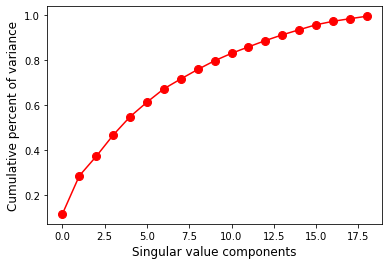

In [23]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [24]:
n = 20
latent_matrix_1_df_original = pd.DataFrame(latent_matrix[:,0:n], index=movies.title.tolist())
latent_matrix_1_df_original.shape

(27278, 19)

**2. Collaborative Filtering**

**Create a User-Item Matrix**

In [17]:
ratings=pd.read_csv('ml-20m/ratings.csv',nrows=10000000)
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [26]:
user_movies_data = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
user_movies_data

userId,1,2,3,4,5,6,7,8,9,10,...,69130,69131,69132,69133,69134,69135,69136,69137,69138,69139
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
mov=movies.iloc[:23304,:]
mov.head()

,movieId,title,genres,Split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,Comedy


In [28]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(user_movies_data)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2, index=mov.title.tolist())

In [29]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),416.395263,75.286890,81.487646,26.431586,56.567960,119.999109,-47.613051,43.383956,148.211623,-14.270614,...,5.082204,-4.833206,-6.133632,0.794569,5.097216,4.802747,9.539876,7.031618,-5.376466,-4.267491
Jumanji (1995),182.832370,65.793601,86.661998,-54.538054,-16.243922,10.172731,-43.969942,36.799028,1.794019,-7.872350,...,-10.132895,-7.263948,22.827761,-5.256698,20.139174,9.847554,-1.216484,-12.126668,-22.269399,4.639994
Grumpier Old Men (1995),78.774242,56.631658,14.579564,-44.873168,-10.176988,3.010760,0.672716,-10.260273,90.670127,-20.912552,...,9.142477,-2.206125,0.710906,-5.397046,-4.367094,7.817490,4.096046,2.258982,4.325187,-4.247037
Waiting to Exhale (1995),18.323947,23.520520,0.056676,-8.926860,-15.237588,2.750825,0.706203,1.692111,11.471888,1.645578,...,-3.985046,-0.072939,3.537995,-1.576021,-0.538743,-0.077273,1.924045,-0.724318,-0.227166,0.803888
Father of the Bride Part II (1995),67.912926,57.375026,22.865847,-42.325063,-21.739419,14.703543,-4.370850,-3.653159,81.806672,-20.705299,...,2.558462,-2.073836,3.190374,-2.864153,-3.984592,-2.484880,1.688259,5.079726,1.473637,-1.749718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Centenarian Who Climbed Out the Window and Vanished, The (Hundraåringen som klev ut genom fönstret och försvann) (2013)",0.044174,-0.007852,0.001918,-0.042594,0.005805,0.001747,-0.090748,-0.074701,-0.022590,0.002998,...,0.013561,-0.026199,0.021403,-0.009966,0.035077,0.034517,-0.047971,-0.025165,0.016266,-0.027455
New Orleans Uncensored (1955),0.067465,-0.036881,-0.014438,-0.049578,-0.098487,-0.033061,0.012454,-0.068304,0.025780,0.029926,...,0.014156,0.025707,0.045734,0.013843,-0.004349,0.004111,0.010944,0.023649,-0.004410,0.044154
Locke (2013),0.034186,-0.021628,-0.029447,-0.049538,-0.077912,0.048073,-0.056242,0.010177,0.013448,0.044222,...,-0.017616,-0.023358,-0.063156,0.017470,0.020443,-0.039637,0.012180,-0.075718,-0.045636,-0.053060
Shinobi No Mono 4: Siege (1964),0.030344,-0.037384,0.027822,-0.011665,-0.019065,-0.046111,-0.015919,-0.009403,0.021488,0.037695,...,-0.016208,0.006284,-0.003869,0.006418,0.026270,-0.013683,0.005353,-0.006636,-0.014380,-0.016296


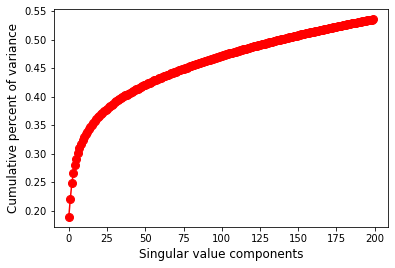

In [30]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [31]:
#Extracting Stopword
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN for empty string
mov['Split'] = mov['Split'].fillna('')

#Applying TF-IDF Vectorizer
tfidf_matrix = tfidf.fit_transform(mov['Split'])
cosine_sim=linear_kernel(tfidf_matrix,tfidf_matrix)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=mov.index.tolist())
print(tfidf_df.shape)


<ipython-input-31-a13763f101d6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mov['Split'] = mov['Split'].fillna('')


(23304, 22)


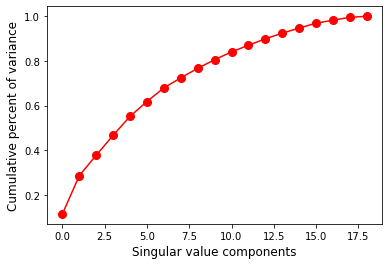

(23304, 19)

In [32]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=mov.title.tolist())
latent_matrix_1_df.shape

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
# dictDf = {'collaborative': score_2} 
similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Shrek the Third (2007),1.0,0.088647,0.544324
"Monsters, Inc. (2001)",1.0,0.182978,0.591489
Turbo (2013),1.0,0.093633,0.546817
"Emperor's New Groove, The (2000)",1.0,0.362898,0.681449
"Adventures of Rocky and Bullwinkle, The (2000)",1.0,0.397431,0.698716
DuckTales: The Movie - Treasure of the Lost Lamp (1990),1.0,0.055626,0.527813
"Wild, The (2006)",1.0,0.040631,0.520315
Toy Story 2 (1999),1.0,0.623526,0.811763
Antz (1998),1.0,0.507522,0.753761
"Tale of Despereaux, The (2008)",1.0,0.047600,0.523800


In [34]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),1.000000,0.623526,0.811763
Star Wars: Episode IV - A New Hope (1977),0.203697,0.587625,0.395661
Independence Day (a.k.a. ID4) (1996),0.188643,0.583258,0.385951
Aladdin (1992),0.765782,0.572198,0.668990
Star Wars: Episode VI - Return of the Jedi (1983),0.203697,0.571116,0.387406
Mission: Impossible (1996),0.213783,0.565983,0.389883
Twister (1996),0.233485,0.562620,0.398052
Back to the Future (1985),0.298185,0.562061,0.430123
James and the Giant Peach (1996),0.857026,0.561142,0.709084
Men in Black (a.k.a. MIB) (1997),0.087419,0.560507,0.323963


In [35]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),1.000000,0.623526,0.811763
Antz (1998),1.000000,0.507522,0.753761
"Bug's Life, A (1998)",0.881032,0.551674,0.716353
James and the Giant Peach (1996),0.857026,0.561142,0.709084
"Adventures of Rocky and Bullwinkle, The (2000)",1.000000,0.397431,0.698716
Space Jam (1996),0.845235,0.527774,0.686504
"Emperor's New Groove, The (2000)",1.000000,0.362898,0.681449
Shrek (2001),0.946635,0.407713,0.677174
Who Framed Roger Rabbit? (1988),0.855802,0.487356,0.671579
Aladdin (1992),0.765782,0.572198,0.668990


**3. Hybrid Recommendation System**

In [36]:
def recommend_similar_movies(title):
    # take the latent vectors for a selected movie from both content 
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [37]:
recommend_similar_movies("Toy Story (1995)")

                                                 content  collaborative  \
Toy Story 2 (1999)                              1.000000       0.623526   
Antz (1998)                                     1.000000       0.507522   
Bug's Life, A (1998)                            0.881032       0.551674   
James and the Giant Peach (1996)                0.857026       0.561142   
Adventures of Rocky and Bullwinkle, The (2000)  1.000000       0.397431   
Space Jam (1996)                                0.845235       0.527774   
Emperor's New Groove, The (2000)                1.000000       0.362898   
Shrek (2001)                                    0.946635       0.407713   
Who Framed Roger Rabbit? (1988)                 0.855802       0.487356   
Aladdin (1992)                                  0.765782       0.572198   
Lord of the Rings, The (1978)                   0.965606       0.355518   

                                                  hybrid  
Toy Story 2 (1999)                      

In [38]:
recommend_similar_movies("GoldenEye (1995)")

                                 content  collaborative    hybrid
Cliffhanger (1993)               1.00000       0.747327  0.873664
Tomorrow Never Dies (1997)       1.00000       0.659322  0.829661
Broken Arrow (1996)              1.00000       0.601775  0.800887
World Is Not Enough, The (1999)  1.00000       0.601672  0.800836
True Lies (1994)                 0.83349       0.686472  0.759981
Con Air (1997)                   1.00000       0.508484  0.754242
Die Hard 2 (1990)                1.00000       0.507248  0.753624
Rock, The (1996)                 1.00000       0.504177  0.752088
Licence to Kill (1989)           1.00000       0.475387  0.737694
View to a Kill, A (1985)         1.00000       0.452630  0.726315
Goldfinger (1964)                1.00000       0.451704  0.725852


In [39]:
recommend_similar_movies("Mission: Impossible (1996)")

                             content  collaborative    hybrid
Rock, The (1996)            0.810065       0.718950  0.764507
Broken Arrow (1996)         0.810065       0.698718  0.754391
Twister (1996)              0.716681       0.770523  0.743602
Executive Decision (1996)   0.810065       0.604431  0.707248
Con Air (1997)              0.810065       0.584034  0.697050
GoldenEye (1995)            0.810065       0.571633  0.690849
Die Hard 2 (1990)           0.810065       0.559233  0.684649
National Treasure (2004)    0.969667       0.395729  0.682698
Tomorrow Never Dies (1997)  0.810065       0.534544  0.672304
Chain Reaction (1996)       0.810065       0.531745  0.670905
Eraser (1996)               0.577601       0.725898  0.651750


**4. Matrix Factorization Recommender**

In [6]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [8]:
ratings_mat=pd.read_csv('ml-20m/ratings.csv',nrows=200000)
ratings_mat.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [10]:
R= np.array(ratings_mat.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [11]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 398.8080
Iteration: 40 ; error = 387.2905
Iteration: 60 ; error = 374.2605
Iteration: 80 ; error = 363.2181
Iteration: 100 ; error = 348.0103

P x Q:
[[3.93766962 3.40712942 3.2954438  ... 3.51617502 3.56198828 3.57862946]
 [4.50699858 3.7235064  3.67170349 ... 3.93631044 3.9792866  3.95268475]
 [4.5195893  3.85449172 3.61555455 ... 3.94372804 4.00990177 4.03349026]
 ...
 [3.61218713 3.00886503 2.75770606 ... 3.06155628 3.1632187  3.16471725]
 [3.98774698 3.3549507  3.2377731  ... 3.52263069 3.57069617 3.54411935]
 [4.38956087 3.64180228 3.51758012 ... 3.77740744 3.81378443 3.85688888]]



In [12]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [13]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [14]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_mat[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.8974


0.8973552521661987

In [15]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [18]:
user_id = 1
pred_user_rating(user_id)

,ratings
movies,
Rebecca (1940),4.443358
Band of Brothers (2001),4.383996
Forrest Gump (1994),4.373052
"Professional, The (Le professionnel) (1981)",4.340164
City of God (Cidade de Deus) (2002),4.332302
Dr. Horrible's Sing-Along Blog (2008),4.329188
"Departed, The (2006)",4.327643
My Neighbor Totoro (Tonari no Totoro) (1988),4.326567
Spirited Away (Sen to Chihiro no kamikakushi) (2001),4.321902


In [19]:
pred_user_rating(50)

,ratings
movies,
Once Upon a Time in the West (C'era una volta il West) (1968),4.781510
Band of Brothers (2001),4.744946
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.724007
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.707948
Dr. Horrible's Sing-Along Blog (2008),4.662158
"Manchurian Candidate, The (1962)",4.659315
"Godfather, The (1972)",4.654395
"Usual Suspects, The (1995)",4.644874
Rebecca (1940),4.640174


In [21]:
import turicreate
from sklearn.model_selection import train_test_split

In [22]:
ratings_train,ratings_test=train_test_split(ratings,test_size=0.25)

In [23]:
train_data = turicreate.SFrame(ratings_train)
test_data = turicreate.SFrame(ratings_test)

In [25]:
popularity_model = turicreate.popularity_recommender.create(train_data, user_id='userId', item_id='movieId', target='rating')

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 7500000 observations with 69139 users and 22209 items.

Data prepared in: 5.44069s

7500000 observations to process; with 22209 unique items.

In [26]:
popularity_recomm = popularity_model.recommend(users=[1,2,3,4,5],k=5)
popularity_recomm.print_rows(num_rows=25)

+--------+---------+-------+------+
| userId | movieId | score | rank |
+--------+---------+-------+------+
|   1    |  102672 |  5.0  |  1   |
|   1    |  127441 |  5.0  |  2   |
|   1    |  103871 |  5.0  |  3   |
|   1    |  106614 |  5.0  |  4   |
|   1    |  33235  |  5.0  |  5   |
|   2    |  102672 |  5.0  |  1   |
|   2    |  127441 |  5.0  |  2   |
|   2    |  103871 |  5.0  |  3   |
|   2    |  106614 |  5.0  |  4   |
|   2    |  33235  |  5.0  |  5   |
|   3    |  102672 |  5.0  |  1   |
|   3    |  127441 |  5.0  |  2   |
|   3    |  103871 |  5.0  |  3   |
|   3    |  106614 |  5.0  |  4   |
|   3    |  33235  |  5.0  |  5   |
|   4    |  102672 |  5.0  |  1   |
|   4    |  127441 |  5.0  |  2   |
|   4    |  103871 |  5.0  |  3   |
|   4    |  106614 |  5.0  |  4   |
|   4    |  33235  |  5.0  |  5   |
|   5    |  102672 |  5.0  |  1   |
|   5    |  127441 |  5.0  |  2   |
|   5    |  103871 |  5.0  |  3   |
|   5    |  106614 |  5.0  |  4   |
|   5    |  33235  |  5.0  |

In [27]:
item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='userId', item_id='movieId', target='rating', similarity_type='cosine')

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 7500000 observations with 69139 users and 22209 items.

Data prepared in: 6.36669s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 17.728ms                       | 1.25       |

| 334.802ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.69s                               | 0                | 1               |

| 5.71s                               | 7.75             | 1749            |

| 8.70s                               | 22.5             | 5024            |

| 11.71s                              | 31.75            | 7075            |

| 14.71s                              | 44.75            | 9975            |

| 17.70s                              | 55.75            | 12419           |

| 20.70s                              | 70.75            | 15740           |

| 23.70s                              | 88               | 19595           |

| 29.77s                              | 100              | 22209           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 31.0533s

In [28]:
item_sim_recomm = item_sim_model.recommend(users=[1,2,3,4,5],k=5)
item_sim_recomm.print_rows(num_rows=25)

+--------+---------+--------------------+------+
| userId | movieId |       score        | rank |
+--------+---------+--------------------+------+
|   1    |   1270  | 0.6336016173715945 |  1   |
|   1    |   2571  | 0.6046816808206064 |  2   |
|   1    |   1240  | 0.5524428813545792 |  3   |
|   1    |   1580  | 0.5313641437777766 |  4   |
|   1    |   1136  |  0.49321443328151  |  5   |
|   2    |   1240  | 0.6777224845664446 |  1   |
|   2    |   1200  | 0.566269455954086  |  2   |
|   2    |   2571  | 0.5646837575491085 |  3   |
|   2    |   1198  | 0.5489348755326382 |  4   |
|   2    |   2916  | 0.546562208685764  |  5   |
|   3    |   1196  | 0.9207768905162811 |  1   |
|   3    |   1265  | 0.713621248404185  |  2   |
|   3    |   2716  | 0.7112339862187703 |  3   |
|   3    |   1291  | 0.7095886198679606 |  4   |
|   3    |   1580  | 0.697670780022939  |  5   |
|   4    |   377   | 1.210067171942104  |  1   |
|   4    |   592   | 1.127517201683738  |  2   |
|   4    |   457   |